# Deutsch-Jozsa-Algorithm

In [1]:
#initialization
# all files according to the requirement are imported here
import numpy as np
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
%matplotlib inline

## Generalised Circuit
First we'll see general circuit and then one particular example will be used:

### Oracle-Circuit

In [2]:
# num is the length of input register
def DeutschJozsaOracle(case, n):
    # Quantum Circuit of oracle is supposed to be returned
    # Oracle circuit consist of n + 1 qubits (n-> input register, 1-> output register)
    
    oracleCircuit = QuantumCircuit(n + 1)
    
    # First consider the case for balanced oracle
    
    if case == "balanced":
        # generate a random number that tells us which CNOTs to wrap in X-gates
        b = np.random.randint(1, 2**n)
        # now format 'ranNum' as a binary string of length n padded with zeros
        b_str = format(b, '0'+ str(n)+'b')
        # now corresponding to qubit if a digit in ranNum_str i s '1' apply X-gate in that qubit
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracleCircuit.x(qubit)
        # apply CNOT gates for each qubit taking control itself and target to output qubit
        for qubit in range(n):
            oracleCircuit.cx(qubit, n)
        # now apply the X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] =='1':
                oracleCircuit.x(qubit)
                
    # Now consider for constant oracle
    if case == "constant":
        # decide the fixed output of the oracle as either 0 or 1
        output = np.random.randint(2)
        if output == 1:
            oracleCircuit.x(n)
            
    oracleGate = oracleCircuit.to_gate()
    oracleGate.name = "Oracle" # to show while displaying circuit
    return oracleGate

### Applying Deutsch - Jozsa - Algo

In [3]:
def DeutschJozsaAlgo(oracle, n):
    dj_circuit = QuantumCircuit(n + 1, n)
    # set the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # Setting up input registers
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Append Oracle to our circuit
    dj_circuit.append(oracle, range(n + 1))
    # Finally perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    for i in range(n):
        dj_circuit.measure(i, i)
    return dj_circuit    

### Using above function to apply DJ algo for n = 4

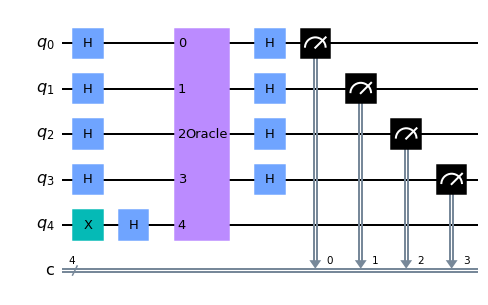

In [4]:
n = 4
oracle_gate = DeutschJozsaOracle('balanced', n)
dj_circuit = DeutschJozsaAlgo(oracle_gate, n)
dj_circuit.draw(output = 'mpl')

### Result on a simulator

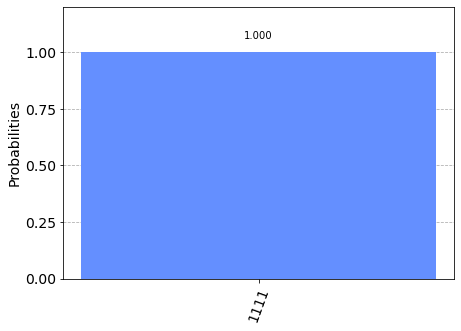

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

### Experiment with real device

In [6]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:
provider = IBMQ.get_provider('ibm-q')
backend = least_busy(provider.backends(filters = lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational == True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [9]:
from qiskit.tools.monitor import job_monitor
# to monitor the execution of job in the queue
shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level = 3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


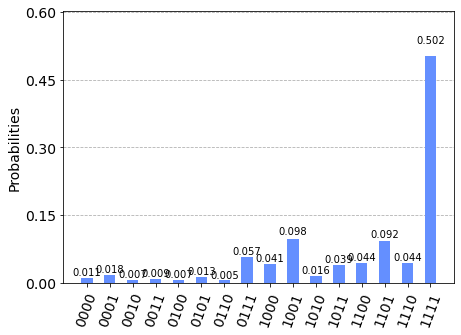

In [10]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

Most likely result is 1111 and the other results are due to error in quantum computing.